# Time Series Forecasting of Soyabean Production (FAOSTAT Data)

Models used:
- ARIMA
- SARIMA
- Auto ARIMA
- Random Forest

Steps:
1. Data preprocessing
2. Log transformation and differencing
3. Stationarity test (ADF)
4. Train-test split
5. Model building
6. Model comparison (MSE, RMSE, RADE)
7. Best model selection
8. Forecast next 5 years
9. Visualization


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")


## Load Dataset


In [2]:
df = pd.read_csv("FAOSTAT_soyabean.csv")

df = df[['Year', 'Value']]
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df = df.sort_values('Year')
df.set_index('Year', inplace=True)

df.head()


,Value
Year,
1961-01-01,957
1962-01-01,11220
1963-01-01,18920
1964-01-01,14000
1965-01-01,17000


## Data Cleaning


In [3]:
df['Value'] = df['Value'].interpolate(method='linear')

Q1 = df['Value'].quantile(0.25)
Q3 = df['Value'].quantile(0.75)
IQR = Q3 - Q1

df = df[(df['Value'] >= Q1 - 1.5*IQR) & (df['Value'] <= Q3 + 1.5*IQR)]


## Historical Data Visualization


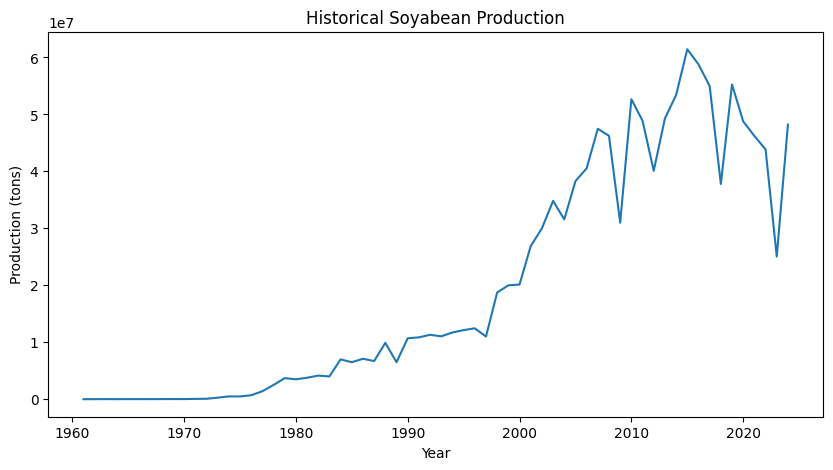

In [4]:
plt.figure(figsize=(10,5))
sns.lineplot(x=df.index, y=df['Value'])
plt.title("Historical Soyabean Production")
plt.xlabel("Year")
plt.ylabel("Production (tons)")
plt.show()


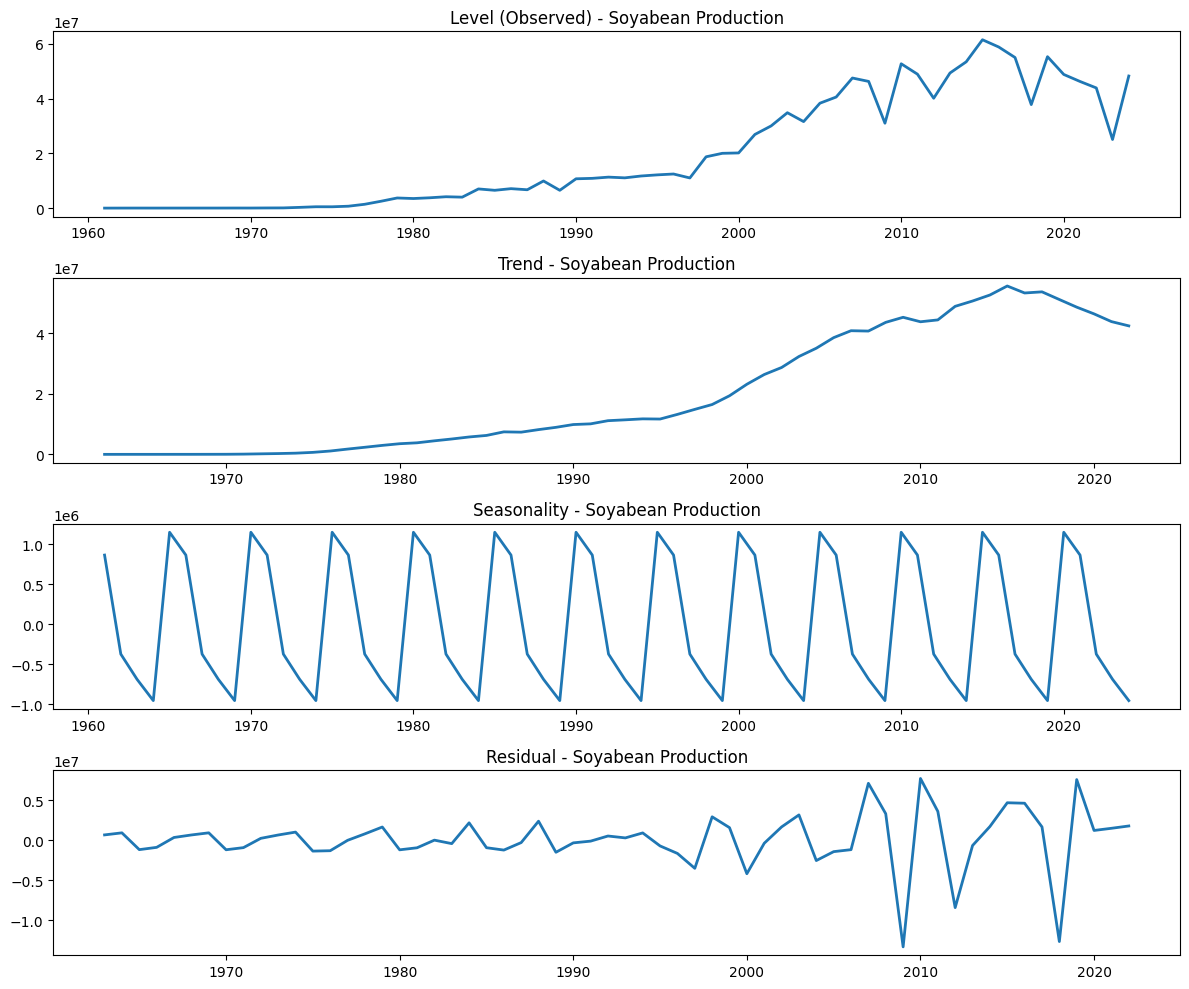

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Select the time series
series = df['Value'].dropna()

# Decomposition
decomposition = seasonal_decompose(series, model='additive', period=5)

# Plot components
plt.figure(figsize=(12,10))

plt.subplot(4,1,1)
plt.plot(decomposition.observed, linewidth=2)
plt.title("Level (Observed) - Soyabean Production")

plt.subplot(4,1,2)
plt.plot(decomposition.trend, linewidth=2)
plt.title("Trend - Soyabean Production")

plt.subplot(4,1,3)
plt.plot(decomposition.seasonal, linewidth=2)
plt.title("Seasonality - Soyabean Production")

plt.subplot(4,1,4)
plt.plot(decomposition.resid, linewidth=2)
plt.title("Residual - Soyabean Production")

plt.tight_layout()
plt.show()


## Log Transformation and Differencing (for ARIMA & SARIMA)


In [5]:
df['Log_Value'] = np.log(df['Value'])
df['Diff_Log_Value'] = df['Log_Value'].diff()
df.dropna(inplace=True)


## Stationarity Test (ADF Test)


In [6]:
adf_result = adfuller(df['Diff_Log_Value'])

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

if adf_result[1] < 0.05:
    print("Series is stationary")
else:
    print("Series is non-stationary")


ADF Statistic: -2.432368533073967
p-value: 0.13280822703633338
Series is non-stationary


## Train-Test Split (80% Train, 20% Test)


In [7]:
train_size = int(len(df)*0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]


## ARIMA Model


In [8]:
arima_model = ARIMA(train['Log_Value'], order=(1,1,1))
arima_fit = arima_model.fit()

arima_pred_log = arima_fit.forecast(steps=len(test))
arima_pred = np.exp(arima_pred_log)


## SARIMA Model


In [9]:
sarima_model = SARIMAX(train['Log_Value'], order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_fit = sarima_model.fit()

sarima_pred_log = sarima_fit.forecast(steps=len(test))
sarima_pred = np.exp(sarima_pred_log)


## Random Forest Model


In [10]:
def create_features(data, lags=3):
    df_feat = data.copy()
    for i in range(1, lags+1):
        df_feat[f'lag_{i}'] = df_feat['Value'].shift(i)
    df_feat.dropna(inplace=True)
    return df_feat

rf_data = create_features(df[['Value']])

train_rf = rf_data.iloc[:train_size-3]
test_rf = rf_data.iloc[train_size-3:]

X_train = train_rf.drop('Value', axis=1)
y_train = train_rf['Value']

X_test = test_rf.drop('Value', axis=1)
y_test = test_rf['Value']

rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)


## Auto ARIMA Model


In [11]:
auto_model = auto_arima(train['Log_Value'], seasonal=False, trace=True)

auto_pred_log = auto_model.predict(n_periods=len(test))
auto_pred = np.exp(auto_pred_log)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=31.899, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=28.878, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=30.697, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=30.761, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=39.758, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=31.737, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.230 seconds


## Model Evaluation (MSE, RMSE, RADE)


In [12]:
def rade(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true - np.mean(y_true)))

def evaluate(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    rade_val = rade(actual, predicted)
    return mse, rmse, rade_val


In [13]:
actual = np.exp(test['Log_Value'])

arima_mse, arima_rmse, arima_rade = evaluate(actual, arima_pred)
sarima_mse, sarima_rmse, sarima_rade = evaluate(actual, sarima_pred)
rf_mse, rf_rmse, rf_rade = evaluate(y_test, rf_pred)
auto_mse, auto_rmse, auto_rade = evaluate(actual, auto_pred)

results = pd.DataFrame({
    "Model": ["ARIMA", "SARIMA", "Random Forest", "Auto ARIMA"],
    "MSE": [arima_mse, sarima_mse, rf_mse, auto_mse],
    "RMSE": [arima_rmse, sarima_rmse, rf_rmse, auto_rmse],
    "RADE": [arima_rade, sarima_rade, rf_rade, auto_rade]
})

results


,Model,MSE,RMSE,RADE
0,ARIMA,7.189869e+14,2.681393e+07,2.925079
1,SARIMA,3.301924e+15,5.746237e+07,6.443750
2,Random Forest,1.161222e+14,1.077600e+07,1.155849
3,Auto ARIMA,3.805296e+16,1.950717e+08,20.765140


## RMSE Bar Plot (Model Comparison)


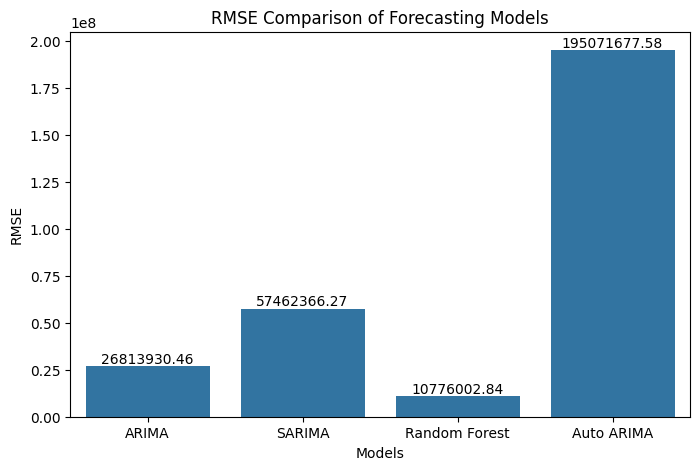

In [14]:
plt.figure(figsize=(8,5))
sns.barplot(x="Model", y="RMSE", data=results)

plt.title("RMSE Comparison of Forecasting Models")
plt.xlabel("Models")
plt.ylabel("RMSE")

for index, row in results.iterrows():
    plt.text(index, row["RMSE"], f"{row['RMSE']:.2f}", ha='center', va='bottom')

plt.show()


## Best Model Selection
The model with the lowest RMSE is selected as the best forecasting model.


In [15]:
best_model = results.loc[results['RMSE'].idxmin()]
best_model


Model             Random Forest
MSE      116122237283524.109375
RMSE            10776002.843519
RADE                   1.155849
Name: 2, dtype: object

## Forecast Next 5 Years using Best Model


In [16]:
final_model = auto_arima(df['Log_Value'], seasonal=False)

n_years = 5
future_years = pd.date_range(df.index[-1] + pd.DateOffset(years=1), periods=n_years, freq='Y')

forecast_log = final_model.predict(n_periods=n_years)
forecast = np.exp(forecast_log)

forecast_df = pd.DataFrame({
    "Year": future_years.year,
    "Forecasted Production (tons)": forecast.round(0).astype(int)
})

forecast_df


,Year,Forecasted Production (tons)
2025-01-01,2025,36824513
2026-01-01,2026,39941677
2027-01-01,2027,37149925
2028-01-01,2028,36293167
2029-01-01,2029,34404439


## Forecast Visualization


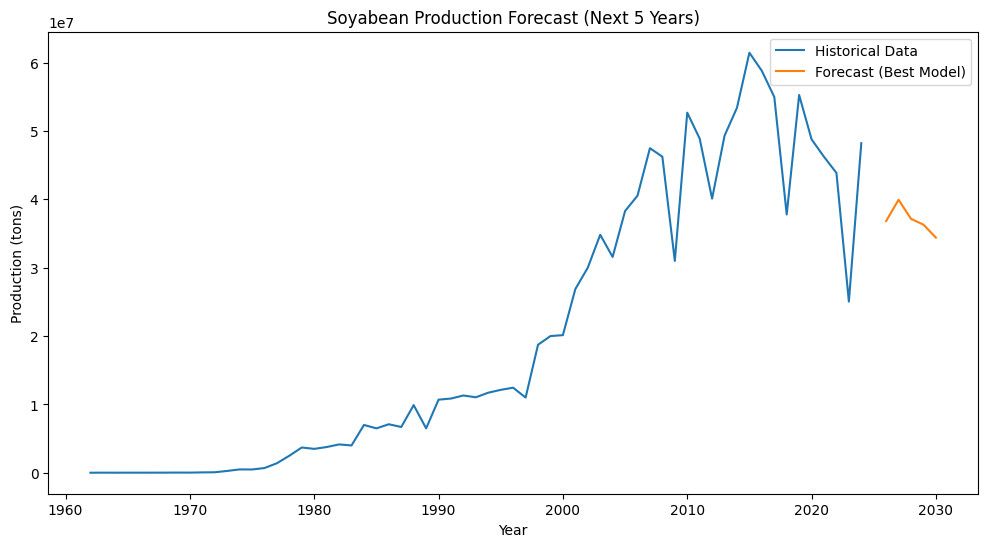

In [17]:
plt.figure(figsize=(12,6))

sns.lineplot(x=df.index, y=df['Value'], label="Historical Data")
sns.lineplot(x=future_years, y=forecast, label="Forecast (Best Model)")

plt.title("Soyabean Production Forecast (Next 5 Years)")
plt.xlabel("Year")
plt.ylabel("Production (tons)")
plt.legend()
plt.show()
